# citeseer

In [8]:
# -*- coding: utf-8 -*-
import os
os.chdir('/root/MGCL')
import numpy as np
import scipy.sparse as sp
import torch
import random
import argparse
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from utils import process
from utils import aug
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from modules.gat import GAT
from net.mview_gat import MVIEW
import time
import torch.nn.functional as F
import dgl
from augf.Citation.cvae_models import VAE
from __future__ import division
from __future__ import print_function
import sys
import copy
import torch.optim as optim
# import augf.Citation.cvae_pretrain
from augf.Citation.utils import accuracy, normalize_adj, normalize_features, sparse_mx_to_torch_sparse_tensor
from tqdm import trange
# from NCLA.gat import GAT
from NCLA.utils import load_network_data, get_train_data, random_planetoid_splits
from NCLA.loss import multihead_contrastive_loss

import dgl
def str_to_bool(value):
    if isinstance(value, bool):
        return value
    if value.lower() in {'false', 'f', '0', 'no', 'n'}:
        return False
    elif value.lower() in {'true', 't', '1', 'yes', 'y'}:
        return True
    raise ValueError(f'{value} is not a valid boolean value')

parser = argparse.ArgumentParser()
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument("--latent_size", type=int, default=10)
parser.add_argument('--seed', type=int, default=2024)
parser.add_argument('--dataset', type=str, default='citeseer')
parser.add_argument('--runs', type=int, default=1)
parser.add_argument('--eval_every', type=int, default=10)
parser.add_argument('--epochs', type=int, default=2000)
parser.add_argument('--lr', type=float, default=0.01)#0.01
parser.add_argument('--batch_size', type=int, default=5)
parser.add_argument('--sample_size', type=int, default=2000)
parser.add_argument('--patience', type=int, default=100)
parser.add_argument('--sparse', type=str_to_bool, default=True)
parser.add_argument('--input_dim', type=int, default=3327)
parser.add_argument('--proj_dim', type=int, default=512)
parser.add_argument('--proj_hid', type=int, default=4096)
parser.add_argument('--pred_dim', type=int, default=512)
parser.add_argument("--pretrain_lr", type=float, default=0.01)
parser.add_argument('--pred_hid', type=int, default=4096)
parser.add_argument('--momentum', type=float, default=0.8)
parser.add_argument('--beta', type=float, default=0.6)
parser.add_argument("--conditional", action='store_true', default=True)
parser.add_argument('--alpha', type=float, default=0.5)
parser.add_argument("--gpu", type=int, default=0,help="which GPU to use. Set -1 to use CPU.")
parser.add_argument("--num-heads", type=int, default=2,help="number of hidden attention heads")###########
parser.add_argument("--num-layers", type=int, default=1,help="number of hidden layers")
parser.add_argument("--num-hidden", type=int, default=128,help="number of hidden units")                    #
parser.add_argument("--tau", type=float, default=1,help="temperature-scales")
parser.add_argument("--in-drop", type=float, default=0.6,help="input feature dropout")
parser.add_argument("--attn-drop", type=float, default=0.5,help="attention dropout")
parser.add_argument('--weight-decay', type=float, default=1e-4,help="weight decay")
parser.add_argument('--negative-slope', type=float, default=0.2,help="the negative slope of leaky relu")
args = parser.parse_known_args()[0]
torch.set_num_threads(4)
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
args.cuda = torch.cuda.is_available()
adj, features, Y = load_network_data(args.dataset)
# features[features > 0] = 1
g = dgl.from_scipy(adj)

if args.gpu >= 0 and torch.cuda.is_available():
    cuda = True
    g = g.int().to(args.gpu)
else:
    cuda = False

features = torch.FloatTensor(features.todense())##################################################################################################

f = open('NCLA_' + args.dataset + '.txt', 'a+')
f.write('\n\n\n{}\n'.format(args))
f.flush()

labels = np.argmax(Y, 1)
print('labels:',labels.shape)
adj = torch.tensor(adj.todense())

all_time = time.time()
num_feats = features.shape[1]
n_classes = Y.shape[1]
n_edges = g.number_of_edges()

# add self loop
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)

# create model
heads = ([args.num_heads] * args.num_layers)
model = GAT(g,
            args.num_layers,
            num_feats,
            args.num_hidden,
            heads,
            F.elu,
            args.in_drop,
            args.attn_drop,
            args.negative_slope)

mview = MVIEW(gnn=model,
                feat_size=args.input_dim,
                projection_size=args.proj_dim,
                projection_hidden_size=args.proj_hid,
                prediction_size=args.pred_dim,
                prediction_hidden_size=args.pred_hid,
                moving_average_decay=args.momentum, beta=args.beta, alpha=args.alpha,tau=args.tau).to(device)
if cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
# use optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# optimizer = torch.optim.Adam(
#     [
#         {'params': list(model.parameters()) + list(mview.parameters()), 'lr': args.lr, 'weight_decay': args.weight_decay}
#     ]
# )
# initialize graph
dur = []
test_acc = 0
counter = 0
min_train_loss = 100
early_stop_counter = 50 ################################################################################
best_t = -1
#开始进行训练
import torch
import random
ori_features = features
svd_u,s,svd_v = torch.svd(features)      #可以进行参数分析
u_mul_s = svd_u @ (torch.diag(s))
v_mul_s = svd_v @ (torch.diag(s))
# del s
print('SVD done.')
k1 = 6  # 保留的奇异值数量#############################################################################6
# 保留较大的奇异值和相应的特征向量
U_truncated = svd_u[:, :k1]
S_truncated = torch.diag(s[:k1])
VT_truncated = svd_v.t()[:k1,:]
# 重建矩阵
aug_features1 = torch.matmul(U_truncated, torch.matmul(S_truncated, VT_truncated))
new_path = 'augf/Citation'
# 改变当前路径
os.chdir(new_path)
import cvae_pretrain
exc_path = sys.path[0]
cvae_model = torch.load("model/{}.pkl".format(args.dataset))
cvae_model.to(device)
cvae_features = features
z = torch.randn([cvae_features.size(0), cvae_model.latent_size]).to(device)
augmented_features = cvae_model.inference(z, cvae_features)
aug_features2 = cvae_pretrain.feature_tensor_normalize(augmented_features).detach()
######改回路径
os.chdir('/root/MGCL')
ori_features = features
for epoch in range(args.epochs):
    if epoch >= 0:
        t0 = time.time()
    model.train()
    mview.train()
    optimizer.zero_grad()
    # heads = model(features)
    _,loss = mview(adj, ori_features, aug_features1, aug_features2)
    loss.backward(retain_graph=True)
    optimizer.step()
    mview.update_ma()
    ori_features = features
######上面是模型训练，下面是模型评估
    model.eval()
    # mview.eval()
    with torch.no_grad():
        online_pred,loss_train = mview(adj, ori_features, aug_features1, aug_features2)
        # loss_train = multihead_contrastive_loss(heads, adj, tau=args.tau)
    # early stop if loss does not decrease for 100 consecutive epochs
    if loss_train < min_train_loss:
        counter = 0
        min_train_loss = loss_train
        best_t = epoch
        torch.save(model.state_dict(), 'best_GAT.pkl')
        torch.save(model.state_dict(), 'best_NCLA.pkl')
    else:
        counter += 1
    if counter >= early_stop_counter:
        print('early stop')
        break
    if epoch >= 0:
        dur.append(time.time() - t0)
    # print("Epoch {:04d} | Time(s) {:.4f} | TrainLoss {:.4f} ".
    #       format(epoch + 1, np.mean(dur), loss_train.item()))####################################
print('Loading {}th epoch'.format(best_t))
model.load_state_dict(torch.load('best_NCLA.pkl'))
##############################
model.eval()#将模型设置为评估模式，并通过模型传递特征以获得嵌入
with torch.no_grad():
    heads = model(features)
    ################
embeds = torch.cat(heads, axis=1)  #从所有头部中串联嵌入
embeds = embeds.detach().cpu()
Accuaracy_test_allK = []
numRandom = 20
for train_num in [20]:
    AccuaracyAll = []
    for random_state in range(numRandom):
        # print(
        #     "\n=============================%d-th random split with training num %d============================="##################################
        #     % (random_state + 1, train_num))
        if train_num == 20:
            if args.dataset in ['cora', 'citeseer', 'pubmed']:
                # train_num per class: 20, val_num: 500, test: 1000
                val_num = 500
                idx_train, idx_val, idx_test = random_planetoid_splits(n_classes, torch.tensor(labels), train_num,
                                                                       random_state)
            else:
                # Coauthor CS, Amazon Computers, Amazon Photo
                # train_num per class: 20, val_num per class: 30, test: rest
                val_num = 30
                idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        else:
            val_num = 0  # do not use a validation set when the training labels are extremely limited
            idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        train_embs = embeds[idx_train, :]
        val_embs = embeds[idx_val, :]
        test_embs = embeds[idx_test, :]
        if train_num == 20:
            # find the best parameter C using validation set
            best_val_score = 0.0
            for param in [1e-4, 1e-3, 1e-2, 0.1, 1,10,100]:
                LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, C=param)
                LR.fit(train_embs, labels[idx_train])
                val_score = LR.score(val_embs, labels[idx_val])
                if val_score > best_val_score:
                    best_val_score = val_score
                    best_parameters = {'C': param}
            LR_best = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, **best_parameters)
            LR_best.fit(train_embs, labels[idx_train])
            y_pred_test = LR_best.predict(test_embs)  # pred label
            # print("Best accuracy on validation set:{:.4f}".format(best_val_score))#################
            # print("Best parameters:{}".format(best_parameters))#########
        else:  # not use a validation set when the training labels are extremely limited
            LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0)
            LR.fit(train_embs, labels[idx_train])
            y_pred_test = LR.predict(test_embs)  # pred label
        test_acc = accuracy_score(labels[idx_test], y_pred_test)
        # print("test accuaray:{:.4f}".format(test_acc))###############################################
        AccuaracyAll.append(test_acc)
    average_acc = np.mean(AccuaracyAll) * 100
    std_acc = np.std(AccuaracyAll) * 100
    print('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.write('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.flush()
    Accuaracy_test_allK.append(average_acc)
f.close()

labels: (3327,)
SVD done.
early stop
Loading 221th epoch
avg accuracy over 20 random splits: 72.5 +/- 1.5, for train_num: 20, val_num:500



In [9]:
embeds.shape

torch.Size([3327, 256])

In [11]:
labels.shape


(3327,)

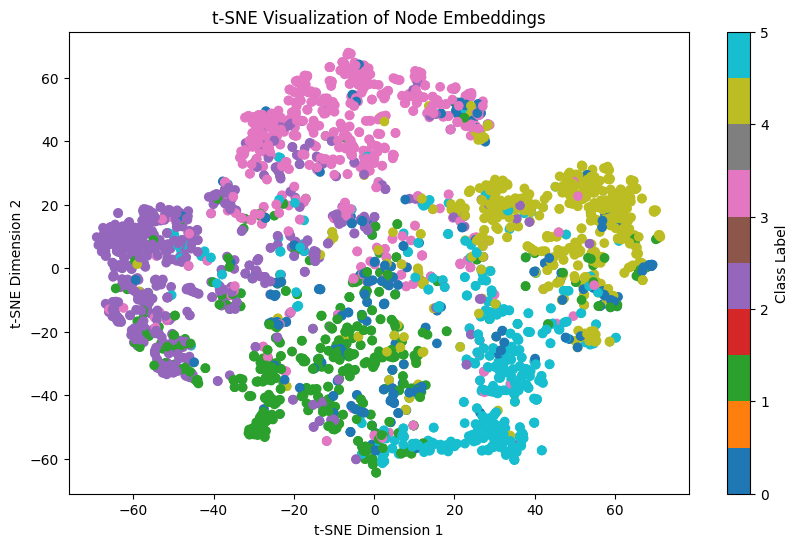

In [14]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# 假设您有一个名为 embeddings 的大小为 [3327, 256] 的 PyTorch 张量

# 将 PyTorch 张量转换为 NumPy 数组
embeddings_np = embeds.numpy()

# 使用 t-SNE 对嵌入表示进行降维
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# 假设您有一个名为 labels 的大小为 [3327] 的 NumPy 数组，表示节点的真实类别标签
# 绘制 t-SNE 可视化结果
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10')
plt.title('t-SNE Visualization of Node Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Class Label')
plt.show()

# 画图

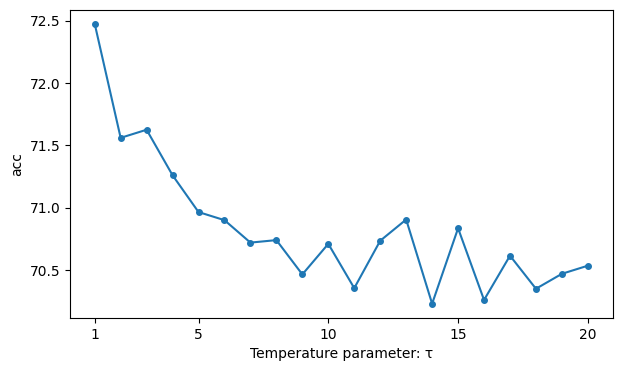

In [24]:
import matplotlib.pyplot as plt
# Temperature_parameter_list = acchhh
# 示例数据
x = list(range(1, 21))
y = Temperature_parameter_list
plt.figure(figsize=(7, 4))  # 宽度为6英寸，高度为3英寸

# 创建折线图
plt.plot(x, y,marker='.', markersize=8)

# 添加标题和标签
plt.xlabel('Temperature parameter: τ')
plt.ylabel('acc')
plt.xticks([1,5,10,15,20], [1,5,10,15,20])
plt.savefig('Temperature parameter1.png', dpi=1000)

# 显示图形
plt.show()

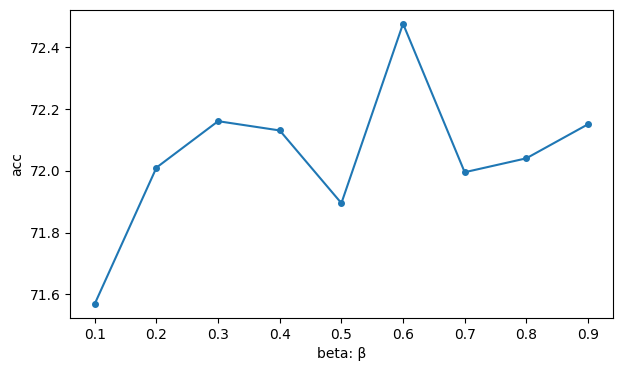

In [3]:

import matplotlib.pyplot as plt
beta_list = acchhh
# 示例数据
x = list(np.arange(0.1
                , 1, 0.1))
y = beta_list
plt.figure(figsize=(7, 4))  # 宽度为6英寸，高度为3英寸

# 创建折线图
plt.plot(x, y,marker='.', markersize=8)

# 添加标题和标签
plt.xlabel('beta: β')
plt.ylabel('acc')
# plt.xticks([1,5,10,15,20], [1,5,10,15,20])
plt.savefig('beta.png', dpi=1000)

# 显示图形
plt.show()

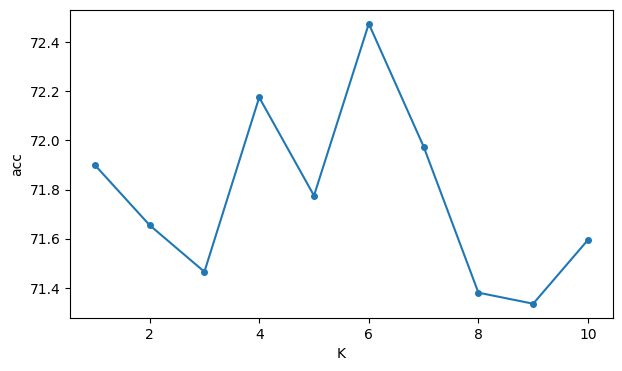

In [5]:

import matplotlib.pyplot as plt
beta_list = acchhh
# 示例数据
x = list(np.arange(1, 11, 1))
y = beta_list
plt.figure(figsize=(7, 4))  # 宽度为6英寸，高度为3英寸

# 创建折线图
plt.plot(x, y,marker='.', markersize=8)

# 添加标题和标签
plt.xlabel('K')
plt.ylabel('acc')
# plt.xticks([1,5,10,15,20], [1,5,10,15,20])
plt.savefig('K.png', dpi=1000)

# 显示图形
plt.show()

# w/o SVD

In [1]:
# -*- coding: utf-8 -*-
import os
os.chdir('/root/MGCL')
import numpy as np
import scipy.sparse as sp
import torch
import random
import argparse
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from utils import process
from utils import aug
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from modules.gat import GAT
from net.mview_gat import MVIEW
import time
import torch.nn.functional as F
import dgl
from augf.Citation.cvae_models import VAE
from __future__ import division
from __future__ import print_function
import sys
import copy
import torch.optim as optim
# import augf.Citation.cvae_pretrain
from augf.Citation.utils import accuracy, normalize_adj, normalize_features, sparse_mx_to_torch_sparse_tensor
from tqdm import trange
# from NCLA.gat import GAT
from NCLA.utils import load_network_data, get_train_data, random_planetoid_splits
from NCLA.loss import multihead_contrastive_loss

import dgl
def str_to_bool(value):
    if isinstance(value, bool):
        return value
    if value.lower() in {'false', 'f', '0', 'no', 'n'}:
        return False
    elif value.lower() in {'true', 't', '1', 'yes', 'y'}:
        return True
    raise ValueError(f'{value} is not a valid boolean value')
parser = argparse.ArgumentParser()
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument("--latent_size", type=int, default=10)
parser.add_argument('--seed', type=int, default=2024)
parser.add_argument('--dataset', type=str, default='citeseer')
parser.add_argument('--runs', type=int, default=1)
parser.add_argument('--eval_every', type=int, default=10)
parser.add_argument('--epochs', type=int, default=2000)
parser.add_argument('--lr', type=float, default=0.01)#0.01
parser.add_argument('--batch_size', type=int, default=5)
parser.add_argument('--sample_size', type=int, default=2000)
parser.add_argument('--patience', type=int, default=100)
parser.add_argument('--sparse', type=str_to_bool, default=True)
parser.add_argument('--input_dim', type=int, default=3327)
parser.add_argument('--proj_dim', type=int, default=512)
parser.add_argument('--proj_hid', type=int, default=4096)
parser.add_argument('--pred_dim', type=int, default=512)
parser.add_argument("--pretrain_lr", type=float, default=0.01)
parser.add_argument('--pred_hid', type=int, default=4096)
parser.add_argument('--momentum', type=float, default=0.8)
parser.add_argument('--beta', type=float, default=0.3)
parser.add_argument("--conditional", action='store_true', default=True)
parser.add_argument('--alpha', type=float, default=0.5)
parser.add_argument("--gpu", type=int, default=0,help="which GPU to use. Set -1 to use CPU.")
parser.add_argument("--num-heads", type=int, default=2,help="number of hidden attention heads")###########
parser.add_argument("--num-layers", type=int, default=1,help="number of hidden layers")
parser.add_argument("--num-hidden", type=int, default=128,help="number of hidden units")                    #
parser.add_argument("--tau", type=float, default=1,help="temperature-scales")
parser.add_argument("--in-drop", type=float, default=0.6,help="input feature dropout")
parser.add_argument("--attn-drop", type=float, default=0.5,help="attention dropout")
parser.add_argument('--weight-decay', type=float, default=1e-4,help="weight decay")
parser.add_argument('--negative-slope', type=float, default=0.2,help="the negative slope of leaky relu")
args = parser.parse_known_args()[0]
torch.set_num_threads(4)
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
args.cuda = torch.cuda.is_available()
adj, features, Y = load_network_data(args.dataset)
# features[features > 0] = 1
g = dgl.from_scipy(adj)

if args.gpu >= 0 and torch.cuda.is_available():
    cuda = True
    g = g.int().to(args.gpu)
else:
    cuda = False

features = torch.FloatTensor(features.todense())##################################################################################################

f = open('NCLA_' + args.dataset + '.txt', 'a+')
f.write('\n\n\n{}\n'.format(args))
f.flush()

labels = np.argmax(Y, 1)
print('labels:',labels.shape)
adj = torch.tensor(adj.todense())

all_time = time.time()
num_feats = features.shape[1]
n_classes = Y.shape[1]
n_edges = g.number_of_edges()

# add self loop
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)

# create model
heads = ([args.num_heads] * args.num_layers)
model = GAT(g,
            args.num_layers,
            num_feats,
            args.num_hidden,
            heads,
            F.elu,
            args.in_drop,
            args.attn_drop,
            args.negative_slope)

mview = MVIEW(gnn=model,
                feat_size=args.input_dim,
                projection_size=args.proj_dim,
                projection_hidden_size=args.proj_hid,
                prediction_size=args.pred_dim,
                prediction_hidden_size=args.pred_hid,
                moving_average_decay=args.momentum, beta=args.beta, alpha=args.alpha).to(device)
if cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
# use optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# optimizer = torch.optim.Adam(
#     [
#         {'params': list(model.parameters()) + list(mview.parameters()), 'lr': args.lr, 'weight_decay': args.weight_decay}
#     ]
# )
# initialize graph
dur = []
test_acc = 0
counter = 0
min_train_loss = 100
early_stop_counter = 50 ################################################################################
best_t = -1
#开始进行训练
import torch
import random
# ori_features = features
# svd_u,s,svd_v = torch.svd(features)      #可以进行参数分析
# u_mul_s = svd_u @ (torch.diag(s))
# v_mul_s = svd_v @ (torch.diag(s))
# # del s
# print('SVD done.')
# k1 = 6      # 保留的奇异值数量#############################################################################6
# # 保留较大的奇异值和相应的特征向量
# U_truncated = svd_u[:, :k1]
# S_truncated = torch.diag(s[:k1])
# VT_truncated = svd_v.t()[:k1,:]
# # 重建矩阵
# aug_features1 = torch.matmul(U_truncated, torch.matmul(S_truncated, VT_truncated))
new_path = 'augf/Citation'
# 改变当前路径
os.chdir(new_path)
import cvae_pretrain
exc_path = sys.path[0]
cvae_model = torch.load("model/{}.pkl".format(args.dataset))
cvae_model.to(device)
cvae_features = features
z1 = torch.randn([cvae_features.size(0), cvae_model.latent_size]).to(device)
augmented_features1 = cvae_model.inference(z1, cvae_features)
aug_features1 = cvae_pretrain.feature_tensor_normalize(augmented_features1).detach()
z2 = torch.randn([cvae_features.size(0), cvae_model.latent_size]).to(device)
augmented_features2 = cvae_model.inference(z2, cvae_features)
aug_features2 = cvae_pretrain.feature_tensor_normalize(augmented_features2).detach()
######改回路径
os.chdir('/root/MGCL')
ori_features = features
for epoch in range(args.epochs):
    if epoch >= 0:
        t0 = time.time()
    model.train()
    mview.train()
    optimizer.zero_grad()
    # heads = model(features)
    _,loss = mview(adj, ori_features, aug_features1, aug_features2)
    loss.backward(retain_graph=True)
    optimizer.step()
    mview.update_ma()
    ori_features = features
######上面是模型训练，下面是模型评估
    model.eval()
    # mview.eval()
    with torch.no_grad():
        online_pred,loss_train = mview(adj, ori_features, aug_features1, aug_features2)
        # loss_train = multihead_contrastive_loss(heads, adj, tau=args.tau)
    # early stop if loss does not decrease for 100 consecutive epochs
    if loss_train < min_train_loss:
        counter = 0
        min_train_loss = loss_train
        best_t = epoch
        torch.save(model.state_dict(), 'best_GAT.pkl')
        torch.save(model.state_dict(), 'best_NCLA.pkl')
    else:
        counter += 1
    if counter >= early_stop_counter:
        print('early stop')
        break
    if epoch >= 0:
        dur.append(time.time() - t0)
    print("Epoch {:04d} | Time(s) {:.4f} | TrainLoss {:.4f} ".
          format(epoch + 1, np.mean(dur), loss_train.item()))
print('Loading {}th epoch'.format(best_t))
model.load_state_dict(torch.load('best_NCLA.pkl'))
##############################
model.eval()#将模型设置为评估模式，并通过模型传递特征以获得嵌入
with torch.no_grad():
    heads = model(features)
    ################
embeds = torch.cat(heads, axis=1)  #从所有头部中串联嵌入
embeds = embeds.detach().cpu()
Accuaracy_test_allK = []
numRandom = 20
for train_num in [20]:
    AccuaracyAll = []
    for random_state in range(numRandom):
        print(
            "\n=============================%d-th random split with training num %d============================="##################################
            % (random_state + 1, train_num))
        if train_num == 20:
            if args.dataset in ['cora', 'citeseer', 'pubmed']:
                # train_num per class: 20, val_num: 500, test: 1000
                val_num = 500
                idx_train, idx_val, idx_test = random_planetoid_splits(n_classes, torch.tensor(labels), train_num,
                                                                       random_state)
            else:
                # Coauthor CS, Amazon Computers, Amazon Photo
                # train_num per class: 20, val_num per class: 30, test: rest
                val_num = 30
                idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        else:
            val_num = 0  # do not use a validation set when the training labels are extremely limited
            idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        train_embs = embeds[idx_train, :]
        val_embs = embeds[idx_val, :]
        test_embs = embeds[idx_test, :]
        if train_num == 20:
            # find the best parameter C using validation set
            best_val_score = 0.0
            for param in [1e-4, 1e-3, 1e-2, 0.1, 1,10,100]:
                LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, C=param)
                LR.fit(train_embs, labels[idx_train])
                val_score = LR.score(val_embs, labels[idx_val])
                if val_score > best_val_score:
                    best_val_score = val_score
                    best_parameters = {'C': param}
            LR_best = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, **best_parameters)
            LR_best.fit(train_embs, labels[idx_train])
            y_pred_test = LR_best.predict(test_embs)  # pred label
            print("Best accuracy on validation set:{:.4f}".format(best_val_score))#################
            print("Best parameters:{}".format(best_parameters))#########
        else:  # not use a validation set when the training labels are extremely limited
            LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0)
            LR.fit(train_embs, labels[idx_train])
            y_pred_test = LR.predict(test_embs)  # pred label
        test_acc = accuracy_score(labels[idx_test], y_pred_test)
        print("test accuaray:{:.4f}".format(test_acc))###############################################
        AccuaracyAll.append(test_acc)
    average_acc = np.mean(AccuaracyAll) * 100
    std_acc = np.std(AccuaracyAll) * 100
    print('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.write('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.flush()
    Accuaracy_test_allK.append(average_acc)
f.close()

labels: (3327,)
Epoch 0001 | Time(s) 1.0478 | TrainLoss 8.2000 
Epoch 0002 | Time(s) 0.6125 | TrainLoss 8.1019 
Epoch 0003 | Time(s) 0.4660 | TrainLoss 8.0506 
Epoch 0004 | Time(s) 0.3922 | TrainLoss 8.0147 
Epoch 0005 | Time(s) 0.3493 | TrainLoss 7.9921 
Epoch 0006 | Time(s) 0.3195 | TrainLoss 7.9796 
Epoch 0007 | Time(s) 0.2980 | TrainLoss 7.9715 
Epoch 0008 | Time(s) 0.2822 | TrainLoss 7.9665 
Epoch 0009 | Time(s) 0.2698 | TrainLoss 7.9626 
Epoch 0010 | Time(s) 0.2616 | TrainLoss 7.9598 
Epoch 0011 | Time(s) 0.2535 | TrainLoss 7.9569 
Epoch 0012 | Time(s) 0.2470 | TrainLoss 7.9536 
Epoch 0013 | Time(s) 0.2412 | TrainLoss 7.9507 
Epoch 0014 | Time(s) 0.2361 | TrainLoss 7.9477 
Epoch 0015 | Time(s) 0.2315 | TrainLoss 7.9454 
Epoch 0016 | Time(s) 0.2278 | TrainLoss 7.9433 
Epoch 0017 | Time(s) 0.2244 | TrainLoss 7.9412 
Epoch 0018 | Time(s) 0.2222 | TrainLoss 7.9394 
Epoch 0019 | Time(s) 0.2195 | TrainLoss 7.9378 
Epoch 0020 | Time(s) 0.2170 | TrainLoss 7.9362 
Epoch 0021 | Time(s) 0.2

# w/o LA

In [6]:
# -*- coding: utf-8 -*-
import os
os.chdir('/root/MGCL')
import numpy as np
import scipy.sparse as sp
import torch
import random
import argparse
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from utils import process
from utils import aug
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from modules.gat import GAT
from net.mview_gat import MVIEW
import time
import torch.nn.functional as F
import dgl
from augf.Citation.cvae_models import VAE
from __future__ import division
from __future__ import print_function
import sys
import copy
import torch.optim as optim
# import augf.Citation.cvae_pretrain
from augf.Citation.utils import accuracy, normalize_adj, normalize_features, sparse_mx_to_torch_sparse_tensor
from tqdm import trange
# from NCLA.gat import GAT
from NCLA.utils import load_network_data, get_train_data, random_planetoid_splits
from NCLA.loss import multihead_contrastive_loss

import dgl
def str_to_bool(value):
    if isinstance(value, bool):
        return value
    if value.lower() in {'false', 'f', '0', 'no', 'n'}:
        return False
    elif value.lower() in {'true', 't', '1', 'yes', 'y'}:
        return True
    raise ValueError(f'{value} is not a valid boolean value')
parser = argparse.ArgumentParser()
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument("--latent_size", type=int, default=10)
parser.add_argument('--seed', type=int, default=2024)
parser.add_argument('--dataset', type=str, default='citeseer')
parser.add_argument('--runs', type=int, default=1)
parser.add_argument('--eval_every', type=int, default=10)
parser.add_argument('--epochs', type=int, default=2000)
parser.add_argument('--lr', type=float, default=0.01)#0.01
parser.add_argument('--batch_size', type=int, default=5)
parser.add_argument('--sample_size', type=int, default=2000)
parser.add_argument('--patience', type=int, default=100)
parser.add_argument('--sparse', type=str_to_bool, default=True)
parser.add_argument('--input_dim', type=int, default=3327)
parser.add_argument('--proj_dim', type=int, default=512)
parser.add_argument('--proj_hid', type=int, default=4096)
parser.add_argument('--pred_dim', type=int, default=512)
parser.add_argument("--pretrain_lr", type=float, default=0.01)
parser.add_argument('--pred_hid', type=int, default=4096)
parser.add_argument('--momentum', type=float, default=0.8)
parser.add_argument('--beta', type=float, default=0.6)
parser.add_argument("--conditional", action='store_true', default=True)
parser.add_argument('--alpha', type=float, default=0.5)
parser.add_argument("--gpu", type=int, default=0,help="which GPU to use. Set -1 to use CPU.")
parser.add_argument("--num-heads", type=int, default=2,help="number of hidden attention heads")###########
parser.add_argument("--num-layers", type=int, default=1,help="number of hidden layers")
parser.add_argument("--num-hidden", type=int, default=128,help="number of hidden units")                    #
parser.add_argument("--tau", type=float, default=1,help="temperature-scales")
parser.add_argument("--in-drop", type=float, default=0.6,help="input feature dropout")
parser.add_argument("--attn-drop", type=float, default=0.5,help="attention dropout")
parser.add_argument('--weight-decay', type=float, default=1e-4,help="weight decay")
parser.add_argument('--negative-slope', type=float, default=0.2,help="the negative slope of leaky relu")
args = parser.parse_known_args()[0]
torch.set_num_threads(4)
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
args.cuda = torch.cuda.is_available()
adj, features, Y = load_network_data(args.dataset)
# features[features > 0] = 1
g = dgl.from_scipy(adj)

if args.gpu >= 0 and torch.cuda.is_available():
    cuda = True
    g = g.int().to(args.gpu)
else:
    cuda = False

features = torch.FloatTensor(features.todense())##################################################################################################

f = open('NCLA_' + args.dataset + '.txt', 'a+')
f.write('\n\n\n{}\n'.format(args))
f.flush()

labels = np.argmax(Y, 1)
print('labels:',labels.shape)
adj = torch.tensor(adj.todense())

all_time = time.time()
num_feats = features.shape[1]
n_classes = Y.shape[1]
n_edges = g.number_of_edges()

# add self loop
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)

# create model
heads = ([args.num_heads] * args.num_layers)
model = GAT(g,
            args.num_layers,
            num_feats,
            args.num_hidden,
            heads,
            F.elu,
            args.in_drop,
            args.attn_drop,
            args.negative_slope)

mview = MVIEW(gnn=model,
                feat_size=args.input_dim,
                projection_size=args.proj_dim,
                projection_hidden_size=args.proj_hid,
                prediction_size=args.pred_dim,
                prediction_hidden_size=args.pred_hid,
                moving_average_decay=args.momentum, beta=args.beta, alpha=args.alpha,tau=args.tau).to(device)
if cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
# use optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# optimizer = torch.optim.Adam(
#     [
#         {'params': list(model.parameters()) + list(mview.parameters()), 'lr': args.lr, 'weight_decay': args.weight_decay}
#     ]
# )
# initialize graph
dur = []
test_acc = 0
counter = 0
min_train_loss = 100
early_stop_counter = 50 ################################################################################
best_t = -1
#开始进行训练
import torch
import random
ori_features = features
svd_u,s,svd_v = torch.svd(features)      #可以进行参数分析
u_mul_s = svd_u @ (torch.diag(s))
v_mul_s = svd_v @ (torch.diag(s))
# del s
print('SVD done.')
k1 = 6      # 保留的奇异值数量#############################################################################6
# 保留较大的奇异值和相应的特征向量
U_truncated = svd_u[:, :k1]
S_truncated = torch.diag(s[:k1])
VT_truncated = svd_v.t()[:k1,:]
# 重建矩阵
aug_features1 = torch.matmul(U_truncated, torch.matmul(S_truncated, VT_truncated))
noise = torch.randn_like(aug_features1) * 0.1  # 生成与结果张量相同大小的随机噪声

# 将噪声添加到结果中
aug_features2 = aug_features1+noise

ori_features = features
for epoch in range(args.epochs):
    if epoch >= 0:
        t0 = time.time()
    model.train()
    mview.train()
    optimizer.zero_grad()
    # heads = model(features)
    _,loss = mview(adj, ori_features, aug_features1, aug_features2)
    loss.backward(retain_graph=True)
    optimizer.step()
    mview.update_ma()
    ori_features = features
######上面是模型训练，下面是模型评估
    model.eval()
    # mview.eval()
    with torch.no_grad():
        online_pred,loss_train = mview(adj, ori_features, aug_features1, aug_features2)
        # loss_train = multihead_contrastive_loss(heads, adj, tau=args.tau)
    # early stop if loss does not decrease for 100 consecutive epochs
    if loss_train < min_train_loss:
        counter = 0
        min_train_loss = loss_train
        best_t = epoch
        torch.save(model.state_dict(), 'best_GAT.pkl')
        torch.save(model.state_dict(), 'best_NCLA.pkl')
    else:
        counter += 1
    if counter >= early_stop_counter:
        print('early stop')
        break
    if epoch >= 0:
        dur.append(time.time() - t0)
    print("Epoch {:04d} | Time(s) {:.4f} | TrainLoss {:.4f} ".
          format(epoch + 1, np.mean(dur), loss_train.item()))
print('Loading {}th epoch'.format(best_t))
model.load_state_dict(torch.load('best_NCLA.pkl'))
##############################
model.eval()#将模型设置为评估模式，并通过模型传递特征以获得嵌入
with torch.no_grad():
    heads = model(features)
    ################
embeds = torch.cat(heads, axis=1)  #从所有头部中串联嵌入
embeds = embeds.detach().cpu()
Accuaracy_test_allK = []
numRandom = 20
for train_num in [20]:
    AccuaracyAll = []
    for random_state in range(numRandom):
        print(
            "\n=============================%d-th random split with training num %d============================="##################################
            % (random_state + 1, train_num))
        if train_num == 20:
            if args.dataset in ['cora', 'citeseer', 'pubmed']:
                # train_num per class: 20, val_num: 500, test: 1000
                val_num = 500
                idx_train, idx_val, idx_test = random_planetoid_splits(n_classes, torch.tensor(labels), train_num,
                                                                       random_state)
            else:
                # Coauthor CS, Amazon Computers, Amazon Photo
                # train_num per class: 20, val_num per class: 30, test: rest
                val_num = 30
                idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        else:
            val_num = 0  # do not use a validation set when the training labels are extremely limited
            idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        train_embs = embeds[idx_train, :]
        val_embs = embeds[idx_val, :]
        test_embs = embeds[idx_test, :]
        if train_num == 20:
            # find the best parameter C using validation set
            best_val_score = 0.0
            for param in [1e-4, 1e-3, 1e-2, 0.1, 1,10,100]:
                LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, C=param)
                LR.fit(train_embs, labels[idx_train])
                val_score = LR.score(val_embs, labels[idx_val])
                if val_score > best_val_score:
                    best_val_score = val_score
                    best_parameters = {'C': param}
            LR_best = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, **best_parameters)
            LR_best.fit(train_embs, labels[idx_train])
            y_pred_test = LR_best.predict(test_embs)  # pred label
            print("Best accuracy on validation set:{:.4f}".format(best_val_score))#################
            print("Best parameters:{}".format(best_parameters))#########
        else:  # not use a validation set when the training labels are extremely limited
            LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0)
            LR.fit(train_embs, labels[idx_train])
            y_pred_test = LR.predict(test_embs)  # pred label
        test_acc = accuracy_score(labels[idx_test], y_pred_test)
        print("test accuaray:{:.4f}".format(test_acc))###############################################
        AccuaracyAll.append(test_acc)
    average_acc = np.mean(AccuaracyAll) * 100
    std_acc = np.std(AccuaracyAll) * 100
    print('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.write('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.flush()
    Accuaracy_test_allK.append(average_acc)
f.close()

labels: (3327,)
SVD done.
Epoch 0001 | Time(s) 0.1790 | TrainLoss 8.3213 
Epoch 0002 | Time(s) 0.1799 | TrainLoss 8.2151 
Epoch 0003 | Time(s) 0.1802 | TrainLoss 8.1493 
Epoch 0004 | Time(s) 0.1790 | TrainLoss 8.1086 
Epoch 0005 | Time(s) 0.1784 | TrainLoss 8.0822 
Epoch 0006 | Time(s) 0.1778 | TrainLoss 8.0656 
Epoch 0007 | Time(s) 0.1771 | TrainLoss 8.0543 
Epoch 0008 | Time(s) 0.1773 | TrainLoss 8.0461 
Epoch 0009 | Time(s) 0.1774 | TrainLoss 8.0405 
Epoch 0010 | Time(s) 0.1775 | TrainLoss 8.0364 
Epoch 0011 | Time(s) 0.1773 | TrainLoss 8.0330 
Epoch 0012 | Time(s) 0.1772 | TrainLoss 8.0300 
Epoch 0013 | Time(s) 0.1769 | TrainLoss 8.0272 
Epoch 0014 | Time(s) 0.1769 | TrainLoss 8.0245 
Epoch 0015 | Time(s) 0.1768 | TrainLoss 8.0220 
Epoch 0016 | Time(s) 0.1768 | TrainLoss 8.0198 
Epoch 0017 | Time(s) 0.1768 | TrainLoss 8.0178 
Epoch 0018 | Time(s) 0.1768 | TrainLoss 8.0159 
Epoch 0019 | Time(s) 0.1767 | TrainLoss 8.0142 
Epoch 0020 | Time(s) 0.1766 | TrainLoss 8.0128 
Epoch 0021 | T

# w/o LA

# cora

In [15]:
# -*- coding: utf-8 -*-
import os
os.chdir('/root/MGCL')
import numpy as np
import scipy.sparse as sp
import torch
import random
import argparse
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from utils import process
from utils import aug
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from modules.gat import GAT
from net.mview_gat import MVIEW
import time
import torch.nn.functional as F
import dgl
from augf.Citation.cvae_models import VAE
from __future__ import division
from __future__ import print_function
import sys
import copy
import torch.optim as optim
# import augf.Citation.cvae_pretrain
from augf.Citation.utils import accuracy, normalize_adj, normalize_features, sparse_mx_to_torch_sparse_tensor
from tqdm import trange
# from NCLA.gat import GAT
from NCLA.utils import load_network_data, get_train_data, random_planetoid_splits
from NCLA.loss import multihead_contrastive_loss

import dgl
def str_to_bool(value):
    if isinstance(value, bool):
        return value
    if value.lower() in {'false', 'f', '0', 'no', 'n'}:
        return False
    elif value.lower() in {'true', 't', '1', 'yes', 'y'}:
        return True
    raise ValueError(f'{value} is not a valid boolean value')

parser = argparse.ArgumentParser()
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument("--latent_size", type=int, default=10)
parser.add_argument('--seed', type=int, default=2024)
parser.add_argument('--dataset', type=str, default='cora')
parser.add_argument('--runs', type=int, default=1)
parser.add_argument('--eval_every', type=int, default=10)
parser.add_argument('--epochs', type=int, default=2000)
parser.add_argument('--lr', type=float, default=0.01)#0.01
parser.add_argument('--batch_size', type=int, default=5)
parser.add_argument('--sample_size', type=int, default=2000)
parser.add_argument('--patience', type=int, default=100)
parser.add_argument('--sparse', type=str_to_bool, default=True)
parser.add_argument('--input_dim', type=int, default=2703)
parser.add_argument('--proj_dim', type=int, default=512)
parser.add_argument('--proj_hid', type=int, default=4096)
parser.add_argument('--pred_dim', type=int, default=512)
parser.add_argument("--pretrain_lr", type=float, default=0.01)
parser.add_argument('--pred_hid', type=int, default=4096)
parser.add_argument('--momentum', type=float, default=0.8)
parser.add_argument('--beta', type=float, default=0.3)
parser.add_argument("--conditional", action='store_true', default=True)
parser.add_argument('--alpha', type=float, default=0.5)
parser.add_argument("--gpu", type=int, default=0,help="which GPU to use. Set -1 to use CPU.")
parser.add_argument("--num-heads", type=int, default=2,help="number of hidden attention heads")###########
parser.add_argument("--num-layers", type=int, default=1,help="number of hidden layers")
parser.add_argument("--num-hidden", type=int, default=128,help="number of hidden units")                    #
parser.add_argument("--tau", type=float, default=1,help="temperature-scales")
parser.add_argument("--in-drop", type=float, default=0.6,help="input feature dropout")
parser.add_argument("--attn-drop", type=float, default=0.5,help="attention dropout")
parser.add_argument('--weight-decay', type=float, default=1e-4,help="weight decay")
parser.add_argument('--negative-slope', type=float, default=0.2,help="the negative slope of leaky relu")
args = parser.parse_known_args()[0]
torch.set_num_threads(4)
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
args.cuda = torch.cuda.is_available()
adj, features, Y = load_network_data(args.dataset)
# features[features > 0] = 1
g = dgl.from_scipy(adj)

if args.gpu >= 0 and torch.cuda.is_available():
    cuda = True
    g = g.int().to(args.gpu)
else:
    cuda = False

features = torch.FloatTensor(features.todense())##################################################################################################

f = open('NCLA_' + args.dataset + '.txt', 'a+')
f.write('\n\n\n{}\n'.format(args))
f.flush()

labels = np.argmax(Y, 1)
print('labels:',labels.shape)
adj = torch.tensor(adj.todense())

all_time = time.time()
num_feats = features.shape[1]
n_classes = Y.shape[1]
n_edges = g.number_of_edges()

# add self loop
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)

# create model
heads = ([args.num_heads] * args.num_layers)
model = GAT(g,
            args.num_layers,
            num_feats,
            args.num_hidden,
            heads,
            F.elu,
            args.in_drop,
            args.attn_drop,
            args.negative_slope)

mview = MVIEW(gnn=model,
                feat_size=args.input_dim,
                projection_size=args.proj_dim,
                projection_hidden_size=args.proj_hid,
                prediction_size=args.pred_dim,
                prediction_hidden_size=args.pred_hid,
                moving_average_decay=args.momentum, beta=args.beta, alpha=args.alpha,tau = args.tau).to(device)
if cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
# use optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# optimizer = torch.optim.Adam(
#     [
#         {'params': list(model.parameters()) + list(mview.parameters()), 'lr': args.lr, 'weight_decay': args.weight_decay}
#     ]
# )
# initialize graph
dur = []
test_acc = 0
counter = 0
min_train_loss = 100
early_stop_counter = 50 ################################################################################
best_t = -1
#开始进行训练
import torch
import random
ori_features = features
svd_u,s,svd_v = torch.svd(features)      #可以进行参数分析
u_mul_s = svd_u @ (torch.diag(s))
v_mul_s = svd_v @ (torch.diag(s))
# del s
print('SVD done.')
k1 =5  # 保留的奇异值数量#############################################################################
# 保留较大的奇异值和相应的特征向量
U_truncated = svd_u[:, :k1]
S_truncated = torch.diag(s[:k1])
VT_truncated = svd_v.t()[:k1,:]
# 重建矩阵
aug_features1 = torch.matmul(U_truncated, torch.matmul(S_truncated, VT_truncated))
new_path = 'augf/Citation'
# 改变当前路径
os.chdir(new_path)
import cvae_pretrain
exc_path = sys.path[0]
cvae_model = torch.load("model/{}.pkl".format(args.dataset))
cvae_model.to(device)
cvae_features = features
z = torch.randn([cvae_features.size(0), cvae_model.latent_size]).to(device)
augmented_features = cvae_model.inference(z, cvae_features)
aug_features2 = cvae_pretrain.feature_tensor_normalize(augmented_features).detach()
######改回路径
os.chdir('/root/MGCL')
ori_features = features
for epoch in range(args.epochs):
    if epoch >= 0:
        t0 = time.time()
    model.train()
    mview.train()
    optimizer.zero_grad()
    # heads = model(features)
    _,loss = mview(adj, ori_features, aug_features1, aug_features2)
    loss.backward(retain_graph=True)
    optimizer.step()
    mview.update_ma()
    ori_features = features
######上面是模型训练，下面是模型评估
    model.eval()
    # mview.eval()
    with torch.no_grad():
        online_pred,loss_train = mview(adj, ori_features, aug_features1, aug_features2)
        # loss_train = multihead_contrastive_loss(heads, adj, tau=args.tau)
    # early stop if loss does not decrease for 100 consecutive epochs
    if loss_train < min_train_loss:
        counter = 0
        min_train_loss = loss_train
        best_t = epoch
        torch.save(model.state_dict(), 'best_GAT.pkl')
        torch.save(model.state_dict(), 'best_NCLA.pkl')
    else:
        counter += 1
    if counter >= early_stop_counter:
        print('early stop')
        break
    if epoch >= 0:
        dur.append(time.time() - t0)
#     print("Epoch {:04d} | Time(s) {:.4f} | TrainLoss {:.4f} ".
#           format(epoch + 1, np.mean(dur), loss_train.item()))
# print('Loading {}th epoch'.format(best_t))
model.load_state_dict(torch.load('best_NCLA.pkl'))
##############################
model.eval()#将模型设置为评估模式，并通过模型传递特征以获得嵌入
with torch.no_grad():
    heads = model(features)
    ################
embeds = torch.cat(heads, axis=1)  #从所有头部中串联嵌入
embeds = embeds.detach().cpu()
Accuaracy_test_allK = []
numRandom = 20
for train_num in [20]:
    AccuaracyAll = []
    for random_state in range(numRandom):
        # print(
        #     "\n=============================%d-th random split with training num %d============================="##################################
        #     % (random_state + 1, train_num))
        if train_num == 20:
            if args.dataset in ['cora', 'citeseer', 'pubmed']:
                # train_num per class: 20, val_num: 500, test: 1000
                val_num = 500
                idx_train, idx_val, idx_test = random_planetoid_splits(n_classes, torch.tensor(labels), train_num,
                                                                       random_state)
            else:
                # Coauthor CS, Amazon Computers, Amazon Photo
                # train_num per class: 20, val_num per class: 30, test: rest
                val_num = 30
                idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        else:
            val_num = 0  # do not use a validation set when the training labels are extremely limited
            idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        train_embs = embeds[idx_train, :]
        val_embs = embeds[idx_val, :]
        test_embs = embeds[idx_test, :]
        if train_num == 20:
            # find the best parameter C using validation set
            best_val_score = 0.0
            for param in [1e-4, 1e-3, 1e-2, 0.1, 1,10,100]:
                LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, C=param)
                LR.fit(train_embs, labels[idx_train])
                val_score = LR.score(val_embs, labels[idx_val])
                if val_score > best_val_score:
                    best_val_score = val_score
                    best_parameters = {'C': param}
            LR_best = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, **best_parameters)
            LR_best.fit(train_embs, labels[idx_train])
            y_pred_test = LR_best.predict(test_embs)  # pred label
            # print("Best accuracy on validation set:{:.4f}".format(best_val_score))#################
            # print("Best parameters:{}".format(best_parameters))#########
        else:  # not use a validation set when the training labels are extremely limited
            LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0)
            LR.fit(train_embs, labels[idx_train])
            y_pred_test = LR.predict(test_embs)  # pred label
        test_acc = accuracy_score(labels[idx_test], y_pred_test)
        # print("test accuaray:{:.4f}".format(test_acc))###############################################
        AccuaracyAll.append(test_acc)
    average_acc = np.mean(AccuaracyAll) * 100
    std_acc = np.std(AccuaracyAll) * 100
    print('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.write('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.flush()
    Accuaracy_test_allK.append(average_acc)
f.close()

labels: (2708,)
SVD done.
early stop
avg accuracy over 20 random splits: 82.5 +/- 1.7, for train_num: 20, val_num:500



# 可视化

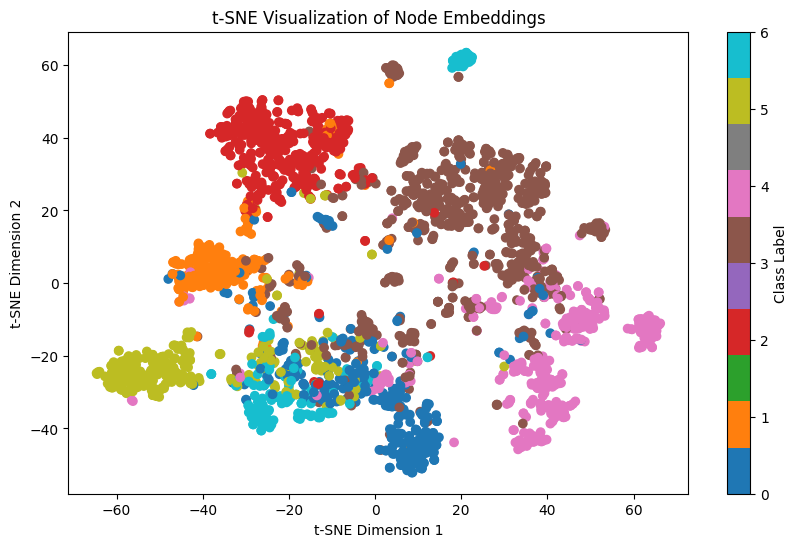

In [16]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# 假设您有一个名为 embeddings 的大小为 [3327, 256] 的 PyTorch 张量

# 将 PyTorch 张量转换为 NumPy 数组
embeddings_np = embeds.numpy()

# 使用 t-SNE 对嵌入表示进行降维
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# 假设您有一个名为 labels 的大小为 [3327] 的 NumPy 数组，表示节点的真实类别标签
# 绘制 t-SNE 可视化结果
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10')
plt.title('t-SNE Visualization of Node Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Class Label')
plt.show()

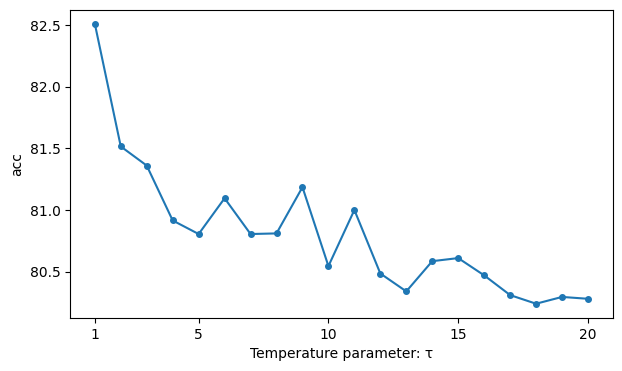

In [31]:
import matplotlib.pyplot as plt
Temperature_parameter_list_cora = acchhh
# 示例数据
x = list(range(1, 21))
y = Temperature_parameter_list_cora
plt.figure(figsize=(7, 4))  # 宽度为6英寸，高度为3英寸

# 创建折线图
plt.plot(x, y,marker='.', markersize=8)

# 添加标题和标签
plt.xlabel('Temperature parameter: τ')
plt.ylabel('acc')
plt.xticks([1,5,10,15,20], [1,5,10,15,20])
plt.savefig('Temperature parameter1.png', dpi=1000)

# 显示图形
plt.show()

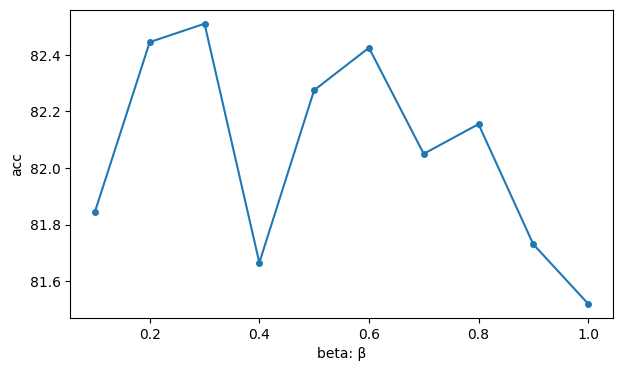

In [3]:

import matplotlib.pyplot as plt
beta_list_cora= acchhh
# 示例数据
x = list(np.arange(0.1, 1.1, 0.1))
y = beta_list_cora
plt.figure(figsize=(7, 4))  # 宽度为6英寸，高度为3英寸

# 创建折线图
plt.plot(x, y,marker='.', markersize=8)

# 添加标题和标签
plt.xlabel('beta: β')
plt.ylabel('acc')
# plt.xticks([1,5,10,15,20], [1,5,10,15,20])
plt.savefig('beta.png', dpi=1000)

# 显示图形
plt.show()

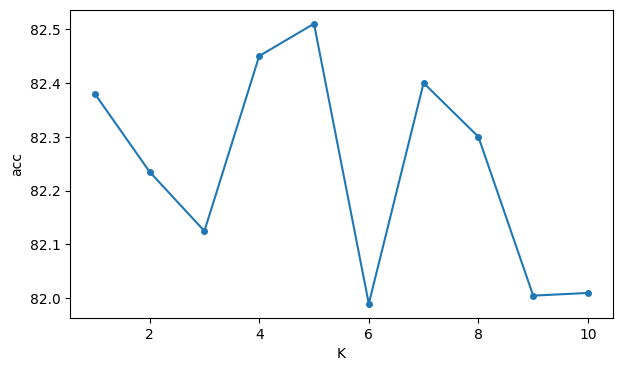

In [2]:

import matplotlib.pyplot as plt
K_list_cora = acchhh
# 示例数据
x = list(np.arange(1, 11, 1))
y = K_list_cora
plt.figure(figsize=(7, 4))  # 宽度为6英寸，高度为3英寸

# 创建折线图
plt.plot(x, y,marker='.', markersize=8)

# 添加标题和标签
plt.xlabel('K')
plt.ylabel('acc')
# plt.xticks([1,5,10,15,20], [1,5,10,15,20])
plt.savefig('K.png', dpi=1000)

# 显示图形
plt.show()

# w/o SVD

In [2]:
# -*- coding: utf-8 -*-
import os
os.chdir('/root/MGCL')
import numpy as np
import scipy.sparse as sp
import torch
import random
import argparse
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from utils import process
from utils import aug
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from modules.gat import GAT
from net.mview_gat import MVIEW
import time
import torch.nn.functional as F
import dgl
from augf.Citation.cvae_models import VAE
from __future__ import division
from __future__ import print_function
import sys
import copy
import torch.optim as optim
# import augf.Citation.cvae_pretrain
from augf.Citation.utils import accuracy, normalize_adj, normalize_features, sparse_mx_to_torch_sparse_tensor
from tqdm import trange
# from NCLA.gat import GAT
from NCLA.utils import load_network_data, get_train_data, random_planetoid_splits
from NCLA.loss import multihead_contrastive_loss

import dgl
def str_to_bool(value):
    if isinstance(value, bool):
        return value
    if value.lower() in {'false', 'f', '0', 'no', 'n'}:
        return False
    elif value.lower() in {'true', 't', '1', 'yes', 'y'}:
        return True
    raise ValueError(f'{value} is not a valid boolean value')
parser = argparse.ArgumentParser()
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument("--latent_size", type=int, default=10)
parser.add_argument('--seed', type=int, default=2024)
parser.add_argument('--dataset', type=str, default='cora')
parser.add_argument('--runs', type=int, default=1)
parser.add_argument('--eval_every', type=int, default=10)
parser.add_argument('--epochs', type=int, default=2000)
parser.add_argument('--lr', type=float, default=0.01)#0.01
parser.add_argument('--batch_size', type=int, default=5)
parser.add_argument('--sample_size', type=int, default=2000)
parser.add_argument('--patience', type=int, default=100)
parser.add_argument('--sparse', type=str_to_bool, default=True)
parser.add_argument('--input_dim', type=int, default=2703)
parser.add_argument('--proj_dim', type=int, default=512)
parser.add_argument('--proj_hid', type=int, default=4096)
parser.add_argument('--pred_dim', type=int, default=512)
parser.add_argument("--pretrain_lr", type=float, default=0.01)
parser.add_argument('--pred_hid', type=int, default=4096)
parser.add_argument('--momentum', type=float, default=0.8)
parser.add_argument('--beta', type=float, default=0.3)
parser.add_argument("--conditional", action='store_true', default=True)
parser.add_argument('--alpha', type=float, default=0.5)
parser.add_argument("--gpu", type=int, default=0,help="which GPU to use. Set -1 to use CPU.")
parser.add_argument("--num-heads", type=int, default=2,help="number of hidden attention heads")###########
parser.add_argument("--num-layers", type=int, default=1,help="number of hidden layers")
parser.add_argument("--num-hidden", type=int, default=128,help="number of hidden units")                    #
parser.add_argument("--tau", type=float, default=1,help="temperature-scales")
parser.add_argument("--in-drop", type=float, default=0.6,help="input feature dropout")
parser.add_argument("--attn-drop", type=float, default=0.5,help="attention dropout")
parser.add_argument('--weight-decay', type=float, default=1e-4,help="weight decay")
parser.add_argument('--negative-slope', type=float, default=0.2,help="the negative slope of leaky relu")
args = parser.parse_known_args()[0]
torch.set_num_threads(4)
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
args.cuda = torch.cuda.is_available()
adj, features, Y = load_network_data(args.dataset)
# features[features > 0] = 1
g = dgl.from_scipy(adj)

if args.gpu >= 0 and torch.cuda.is_available():
    cuda = True
    g = g.int().to(args.gpu)
else:
    cuda = False

features = torch.FloatTensor(features.todense())##################################################################################################

f = open('NCLA_' + args.dataset + '.txt', 'a+')
f.write('\n\n\n{}\n'.format(args))
f.flush()

labels = np.argmax(Y, 1)
print('labels:',labels.shape)
adj = torch.tensor(adj.todense())

all_time = time.time()
num_feats = features.shape[1]
n_classes = Y.shape[1]
n_edges = g.number_of_edges()

# add self loop
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)

# create model
heads = ([args.num_heads] * args.num_layers)
model = GAT(g,
            args.num_layers,
            num_feats,
            args.num_hidden,
            heads,
            F.elu,
            args.in_drop,
            args.attn_drop,
            args.negative_slope)

mview = MVIEW(gnn=model,
                feat_size=args.input_dim,
                projection_size=args.proj_dim,
                projection_hidden_size=args.proj_hid,
                prediction_size=args.pred_dim,
                prediction_hidden_size=args.pred_hid,
                moving_average_decay=args.momentum, beta=args.beta, alpha=args.alpha).to(device)
if cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
# use optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# optimizer = torch.optim.Adam(
#     [
#         {'params': list(model.parameters()) + list(mview.parameters()), 'lr': args.lr, 'weight_decay': args.weight_decay}
#     ]
# )
# initialize graph
dur = []
test_acc = 0
counter = 0
min_train_loss = 100
early_stop_counter = 50 ################################################################################
best_t = -1
#开始进行训练
import torch
import random
new_path = 'augf/Citation'
# 改变当前路径
os.chdir(new_path)
import cvae_pretrain
exc_path = sys.path[0]
cvae_model = torch.load("model/{}.pkl".format(args.dataset))
cvae_model.to(device)
cvae_features = features
z1 = torch.randn([cvae_features.size(0), cvae_model.latent_size]).to(device)
augmented_features1 = cvae_model.inference(z1, cvae_features)
aug_features1 = cvae_pretrain.feature_tensor_normalize(augmented_features1).detach()

z2 = torch.randn([cvae_features.size(0), cvae_model.latent_size]).to(device)
augmented_features2 = cvae_model.inference(z2, cvae_features)
aug_features2 = cvae_pretrain.feature_tensor_normalize(augmented_features2).detach()
######改回路径
os.chdir('/root/MGCL')
ori_features = features
for epoch in range(args.epochs):
    if epoch >= 0:
        t0 = time.time()
    model.train()
    mview.train()
    optimizer.zero_grad()
    # heads = model(features)
    _,loss = mview(adj, ori_features, aug_features1, aug_features2)
    loss.backward(retain_graph=True)
    optimizer.step()
    mview.update_ma()
    ori_features = features
######上面是模型训练，下面是模型评估
    model.eval()
    # mview.eval()
    with torch.no_grad():
        online_pred,loss_train = mview(adj, ori_features, aug_features1, aug_features2)
        # loss_train = multihead_contrastive_loss(heads, adj, tau=args.tau)
    # early stop if loss does not decrease for 100 consecutive epochs
    if loss_train < min_train_loss:
        counter = 0
        min_train_loss = loss_train
        best_t = epoch
        torch.save(model.state_dict(), 'best_GAT.pkl')
        torch.save(model.state_dict(), 'best_NCLA.pkl')
    else:
        counter += 1
    if counter >= early_stop_counter:
        print('early stop')
        break
    if epoch >= 0:
        dur.append(time.time() - t0)
    print("Epoch {:04d} | Time(s) {:.4f} | TrainLoss {:.4f} ".
          format(epoch + 1, np.mean(dur), loss_train.item()))
print('Loading {}th epoch'.format(best_t))
model.load_state_dict(torch.load('best_NCLA.pkl'))
##############################
model.eval()#将模型设置为评估模式，并通过模型传递特征以获得嵌入
with torch.no_grad():
    heads = model(features)
    ################
embeds = torch.cat(heads, axis=1)  #从所有头部中串联嵌入
embeds = embeds.detach().cpu()
Accuaracy_test_allK = []
numRandom = 20
for train_num in [20]:
    AccuaracyAll = []
    for random_state in range(numRandom):
        print(
            "\n=============================%d-th random split with training num %d============================="##################################
            % (random_state + 1, train_num))
        if train_num == 20:
            if args.dataset in ['cora', 'citeseer', 'pubmed']:
                # train_num per class: 20, val_num: 500, test: 1000
                val_num = 500
                idx_train, idx_val, idx_test = random_planetoid_splits(n_classes, torch.tensor(labels), train_num,
                                                                       random_state)
            else:
                # Coauthor CS, Amazon Computers, Amazon Photo
                # train_num per class: 20, val_num per class: 30, test: rest
                val_num = 30
                idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        else:
            val_num = 0  # do not use a validation set when the training labels are extremely limited
            idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        train_embs = embeds[idx_train, :]
        val_embs = embeds[idx_val, :]
        test_embs = embeds[idx_test, :]
        if train_num == 20:
            # find the best parameter C using validation set
            best_val_score = 0.0
            for param in [1e-4, 1e-3, 1e-2, 0.1, 1,10,100]:
                LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, C=param)
                LR.fit(train_embs, labels[idx_train])
                val_score = LR.score(val_embs, labels[idx_val])
                if val_score > best_val_score:
                    best_val_score = val_score
                    best_parameters = {'C': param}
            LR_best = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, **best_parameters)
            LR_best.fit(train_embs, labels[idx_train])
            y_pred_test = LR_best.predict(test_embs)  # pred label
            print("Best accuracy on validation set:{:.4f}".format(best_val_score))#################
            print("Best parameters:{}".format(best_parameters))#########
        else:  # not use a validation set when the training labels are extremely limited
            LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0)
            LR.fit(train_embs, labels[idx_train])
            y_pred_test = LR.predict(test_embs)  # pred label
        test_acc = accuracy_score(labels[idx_test], y_pred_test)
        print("test accuaray:{:.4f}".format(test_acc))###############################################
        AccuaracyAll.append(test_acc)
    average_acc = np.mean(AccuaracyAll) * 100
    std_acc = np.std(AccuaracyAll) * 100
    print('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.write('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.flush()
    Accuaracy_test_allK.append(average_acc)
f.close()

labels: (2708,)
Epoch 0001 | Time(s) 0.1289 | TrainLoss 8.0474 
Epoch 0002 | Time(s) 0.1311 | TrainLoss 7.9818 
Epoch 0003 | Time(s) 0.1290 | TrainLoss 7.9242 
Epoch 0004 | Time(s) 0.1297 | TrainLoss 7.8811 
Epoch 0005 | Time(s) 0.1283 | TrainLoss 7.8504 
Epoch 0006 | Time(s) 0.1284 | TrainLoss 7.8284 
Epoch 0007 | Time(s) 0.1275 | TrainLoss 7.8122 
Epoch 0008 | Time(s) 0.1274 | TrainLoss 7.8005 
Epoch 0009 | Time(s) 0.1269 | TrainLoss 7.7916 
Epoch 0010 | Time(s) 0.1268 | TrainLoss 7.7852 
Epoch 0011 | Time(s) 0.1270 | TrainLoss 7.7800 
Epoch 0012 | Time(s) 0.1270 | TrainLoss 7.7759 
Epoch 0013 | Time(s) 0.1267 | TrainLoss 7.7727 
Epoch 0014 | Time(s) 0.1270 | TrainLoss 7.7694 
Epoch 0015 | Time(s) 0.1268 | TrainLoss 7.7666 
Epoch 0016 | Time(s) 0.1267 | TrainLoss 7.7640 
Epoch 0017 | Time(s) 0.1266 | TrainLoss 7.7614 
Epoch 0018 | Time(s) 0.1264 | TrainLoss 7.7588 
Epoch 0019 | Time(s) 0.1263 | TrainLoss 7.7562 
Epoch 0020 | Time(s) 0.1263 | TrainLoss 7.7543 
Epoch 0021 | Time(s) 0.1

In [7]:
# -*- coding: utf-8 -*-
import os
os.chdir('/root/MGCL')
import numpy as np
import scipy.sparse as sp
import torch
import random
import argparse
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from utils import process
from utils import aug
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from modules.gat import GAT
from net.mview_gat import MVIEW
import time
import torch.nn.functional as F
import dgl
from augf.Citation.cvae_models import VAE
from __future__ import division
from __future__ import print_function
import sys
import copy
import torch.optim as optim
# import augf.Citation.cvae_pretrain
from augf.Citation.utils import accuracy, normalize_adj, normalize_features, sparse_mx_to_torch_sparse_tensor
from tqdm import trange
# from NCLA.gat import GAT
from NCLA.utils import load_network_data, get_train_data, random_planetoid_splits
from NCLA.loss import multihead_contrastive_loss

import dgl
def str_to_bool(value):
    if isinstance(value, bool):
        return value
    if value.lower() in {'false', 'f', '0', 'no', 'n'}:
        return False
    elif value.lower() in {'true', 't', '1', 'yes', 'y'}:
        return True
    raise ValueError(f'{value} is not a valid boolean value')
parser = argparse.ArgumentParser()
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument("--latent_size", type=int, default=10)
parser.add_argument('--seed', type=int, default=2024)
parser.add_argument('--dataset', type=str, default='cora')
parser.add_argument('--runs', type=int, default=1)
parser.add_argument('--eval_every', type=int, default=10)
parser.add_argument('--epochs', type=int, default=2000)
parser.add_argument('--lr', type=float, default=0.01)#0.01
parser.add_argument('--batch_size', type=int, default=5)
parser.add_argument('--sample_size', type=int, default=2000)
parser.add_argument('--patience', type=int, default=100)
parser.add_argument('--sparse', type=str_to_bool, default=True)
parser.add_argument('--input_dim', type=int, default=2708)
parser.add_argument('--proj_dim', type=int, default=512)
parser.add_argument('--proj_hid', type=int, default=4096)
parser.add_argument('--pred_dim', type=int, default=512)
parser.add_argument("--pretrain_lr", type=float, default=0.01)
parser.add_argument('--pred_hid', type=int, default=4096)
parser.add_argument('--momentum', type=float, default=0.8)
parser.add_argument('--beta', type=float, default=0.3)
parser.add_argument("--conditional", action='store_true', default=True)
parser.add_argument('--alpha', type=float, default=0.5)
parser.add_argument("--gpu", type=int, default=0,help="which GPU to use. Set -1 to use CPU.")
parser.add_argument("--num-heads", type=int, default=2,help="number of hidden attention heads")###########
parser.add_argument("--num-layers", type=int, default=1,help="number of hidden layers")
parser.add_argument("--num-hidden", type=int, default=128,help="number of hidden units")                    #
parser.add_argument("--tau", type=float, default=1,help="temperature-scales")
parser.add_argument("--in-drop", type=float, default=0.6,help="input feature dropout")
parser.add_argument("--attn-drop", type=float, default=0.5,help="attention dropout")
parser.add_argument('--weight-decay', type=float, default=1e-4,help="weight decay")
parser.add_argument('--negative-slope', type=float, default=0.2,help="the negative slope of leaky relu")
args = parser.parse_known_args()[0]
torch.set_num_threads(4)
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
args.cuda = torch.cuda.is_available()
adj, features, Y = load_network_data(args.dataset)
# features[features > 0] = 1
g = dgl.from_scipy(adj)

if args.gpu >= 0 and torch.cuda.is_available():
    cuda = True
    g = g.int().to(args.gpu)
else:
    cuda = False

features = torch.FloatTensor(features.todense())##################################################################################################

f = open('NCLA_' + args.dataset + '.txt', 'a+')
f.write('\n\n\n{}\n'.format(args))
f.flush()

labels = np.argmax(Y, 1)
print('labels:',labels.shape)
adj = torch.tensor(adj.todense())

all_time = time.time()
num_feats = features.shape[1]
n_classes = Y.shape[1]
n_edges = g.number_of_edges()

# add self loop
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)

# create model
heads = ([args.num_heads] * args.num_layers)
model = GAT(g,
            args.num_layers,
            num_feats,
            args.num_hidden,
            heads,
            F.elu,
            args.in_drop,
            args.attn_drop,
            args.negative_slope)

mview = MVIEW(gnn=model,
                feat_size=args.input_dim,
                projection_size=args.proj_dim,
                projection_hidden_size=args.proj_hid,
                prediction_size=args.pred_dim,
                prediction_hidden_size=args.pred_hid,
                moving_average_decay=args.momentum, beta=args.beta, alpha=args.alpha,tau=args.tau).to(device)
if cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
# use optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# optimizer = torch.optim.Adam(
#     [
#         {'params': list(model.parameters()) + list(mview.parameters()), 'lr': args.lr, 'weight_decay': args.weight_decay}
#     ]
# )
# initialize graph
dur = []
test_acc = 0
counter = 0
min_train_loss = 100
early_stop_counter = 50 ################################################################################
best_t = -1
#开始进行训练
import torch
import random
ori_features = features
svd_u,s,svd_v = torch.svd(features)      #可以进行参数分析
u_mul_s = svd_u @ (torch.diag(s))
v_mul_s = svd_v @ (torch.diag(s))
# del s
print('SVD done.')
k1 = 5      # 保留的奇异值数量#############################################################################6
# 保留较大的奇异值和相应的特征向量
U_truncated = svd_u[:, :k1]
S_truncated = torch.diag(s[:k1])
VT_truncated = svd_v.t()[:k1,:]
# 重建矩阵
aug_features1 = torch.matmul(U_truncated, torch.matmul(S_truncated, VT_truncated))
noise = torch.randn_like(aug_features1) * 0.1  # 生成与结果张量相同大小的随机噪声

# 将噪声添加到结果中
aug_features2 = aug_features1+noise

ori_features = features
for epoch in range(args.epochs):
    if epoch >= 0:
        t0 = time.time()
    model.train()
    mview.train()
    optimizer.zero_grad()
    # heads = model(features)
    _,loss = mview(adj, ori_features, aug_features1, aug_features2)
    loss.backward(retain_graph=True)
    optimizer.step()
    mview.update_ma()
    ori_features = features
######上面是模型训练，下面是模型评估
    model.eval()
    # mview.eval()
    with torch.no_grad():
        online_pred,loss_train = mview(adj, ori_features, aug_features1, aug_features2)
        # loss_train = multihead_contrastive_loss(heads, adj, tau=args.tau)
    # early stop if loss does not decrease for 100 consecutive epochs
    if loss_train < min_train_loss:
        counter = 0
        min_train_loss = loss_train
        best_t = epoch
        torch.save(model.state_dict(), 'best_GAT.pkl')
        torch.save(model.state_dict(), 'best_NCLA.pkl')
    else:
        counter += 1
    if counter >= early_stop_counter:
        print('early stop')
        break
    if epoch >= 0:
        dur.append(time.time() - t0)
    print("Epoch {:04d} | Time(s) {:.4f} | TrainLoss {:.4f} ".
          format(epoch + 1, np.mean(dur), loss_train.item()))
print('Loading {}th epoch'.format(best_t))
model.load_state_dict(torch.load('best_NCLA.pkl'))
##############################
model.eval()#将模型设置为评估模式，并通过模型传递特征以获得嵌入
with torch.no_grad():
    heads = model(features)
    ################
embeds = torch.cat(heads, axis=1)  #从所有头部中串联嵌入
embeds = embeds.detach().cpu()
Accuaracy_test_allK = []
numRandom = 20
for train_num in [20]:
    AccuaracyAll = []
    for random_state in range(numRandom):
        print(
            "\n=============================%d-th random split with training num %d============================="##################################
            % (random_state + 1, train_num))
        if train_num == 20:
            if args.dataset in ['cora', 'citeseer', 'pubmed']:
                # train_num per class: 20, val_num: 500, test: 1000
                val_num = 500
                idx_train, idx_val, idx_test = random_planetoid_splits(n_classes, torch.tensor(labels), train_num,
                                                                       random_state)
            else:
                # Coauthor CS, Amazon Computers, Amazon Photo
                # train_num per class: 20, val_num per class: 30, test: rest
                val_num = 30
                idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        else:
            val_num = 0  # do not use a validation set when the training labels are extremely limited
            idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        train_embs = embeds[idx_train, :]
        val_embs = embeds[idx_val, :]
        test_embs = embeds[idx_test, :]
        if train_num == 20:
            # find the best parameter C using validation set
            best_val_score = 0.0
            for param in [1e-4, 1e-3, 1e-2, 0.1, 1,10,100]:
                LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, C=param)
                LR.fit(train_embs, labels[idx_train])
                val_score = LR.score(val_embs, labels[idx_val])
                if val_score > best_val_score:
                    best_val_score = val_score
                    best_parameters = {'C': param}
            LR_best = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, **best_parameters)
            LR_best.fit(train_embs, labels[idx_train])
            y_pred_test = LR_best.predict(test_embs)  # pred label
            print("Best accuracy on validation set:{:.4f}".format(best_val_score))#################
            print("Best parameters:{}".format(best_parameters))#########
        else:  # not use a validation set when the training labels are extremely limited
            LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0)
            LR.fit(train_embs, labels[idx_train])
            y_pred_test = LR.predict(test_embs)  # pred label
        test_acc = accuracy_score(labels[idx_test], y_pred_test)
        print("test accuaray:{:.4f}".format(test_acc))###############################################
        AccuaracyAll.append(test_acc)
    average_acc = np.mean(AccuaracyAll) * 100
    std_acc = np.std(AccuaracyAll) * 100
    print('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.write('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.flush()
    Accuaracy_test_allK.append(average_acc)
f.close()

labels: (2708,)
SVD done.
Epoch 0001 | Time(s) 0.1255 | TrainLoss 8.1152 
Epoch 0002 | Time(s) 0.1258 | TrainLoss 8.0538 
Epoch 0003 | Time(s) 0.1279 | TrainLoss 7.9953 
Epoch 0004 | Time(s) 0.1281 | TrainLoss 7.9453 
Epoch 0005 | Time(s) 0.1285 | TrainLoss 7.9086 
Epoch 0006 | Time(s) 0.1290 | TrainLoss 7.8836 
Epoch 0007 | Time(s) 0.1288 | TrainLoss 7.8667 
Epoch 0008 | Time(s) 0.1288 | TrainLoss 7.8547 
Epoch 0009 | Time(s) 0.1284 | TrainLoss 7.8463 
Epoch 0010 | Time(s) 0.1283 | TrainLoss 7.8399 
Epoch 0011 | Time(s) 0.1282 | TrainLoss 7.8348 
Epoch 0012 | Time(s) 0.1279 | TrainLoss 7.8312 
Epoch 0013 | Time(s) 0.1276 | TrainLoss 7.8276 
Epoch 0014 | Time(s) 0.1278 | TrainLoss 7.8242 
Epoch 0015 | Time(s) 0.1277 | TrainLoss 7.8210 
Epoch 0016 | Time(s) 0.1279 | TrainLoss 7.8182 
Epoch 0017 | Time(s) 0.1279 | TrainLoss 7.8147 
Epoch 0018 | Time(s) 0.1277 | TrainLoss 7.8120 
Epoch 0019 | Time(s) 0.1276 | TrainLoss 7.8094 
Epoch 0020 | Time(s) 0.1275 | TrainLoss 7.8069 
Epoch 0021 | T

# Pubmed

In [1]:
# -*- coding: utf-8 -*-
import os
os.chdir('/root/MGCL')
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "1:1000"

import numpy as np
import scipy.sparse as sp
import torch
import random
import argparse
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from utils import process
from utils import aug
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from modules.gat import GAT
from net.mview_gat_pub import MVIEW
import time
import torch.nn.functional as F
import dgl
from augf.Citation.cvae_models import VAE
from __future__ import division
from __future__ import print_function
import sys
import copy
import torch.optim as optim
# import augf.Citation.cvae_pretrain
from augf.Citation.utils import accuracy, normalize_adj, normalize_features, sparse_mx_to_torch_sparse_tensor
from tqdm import trange
# from NCLA.gat import GAT
from NCLA.utils import load_network_data, get_train_data, random_planetoid_splits
from NCLA.loss import multihead_contrastive_loss

import dgl
def str_to_bool(value):
    if isinstance(value, bool):
        return value
    if value.lower() in {'false', 'f', '0', 'no', 'n'}:
        return False
    elif value.lower() in {'true', 't', '1', 'yes', 'y'}:
        return True
    raise ValueError(f'{value} is not a valid boolean value')
parser = argparse.ArgumentParser()
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument("--latent_size", type=int, default=10)
parser.add_argument('--seed', type=int, default=2024)
parser.add_argument('--dataset', type=str, default='pubmed')
parser.add_argument('--runs', type=int, default=1)
parser.add_argument('--eval_every', type=int, default=10)
parser.add_argument('--epochs', type=int, default=2000)
parser.add_argument('--lr', type=float, default=0.01)#0.01
parser.add_argument('--batch_size', type=int, default=5)
parser.add_argument('--sample_size', type=int, default=2000)
parser.add_argument('--patience', type=int, default=100)
parser.add_argument('--sparse', type=str_to_bool, default=True)
parser.add_argument('--input_dim', type=int, default=19717)
parser.add_argument('--proj_dim', type=int, default=512)
parser.add_argument('--proj_hid', type=int, default=4096)
parser.add_argument('--pred_dim', type=int, default=512)
parser.add_argument("--pretrain_lr", type=float, default=0.01)
parser.add_argument('--pred_hid', type=int, default=4096)
parser.add_argument('--momentum', type=float, default=0.8)
parser.add_argument('--beta', type=float, default=0.3)
parser.add_argument("--conditional", action='store_true', default=True)
parser.add_argument('--alpha', type=float, default=0.5)
parser.add_argument("--gpu", type=int, default=0,help="which GPU to use. Set -1 to use CPU.")
parser.add_argument("--num-heads", type=int, default=2,help="number of hidden attention heads")###########
parser.add_argument("--num-layers", type=int, default=1,help="number of hidden layers")
parser.add_argument("--num-hidden", type=int, default=128,help="number of hidden units")                    #
parser.add_argument("--tau", type=float, default=1,help="temperature-scales")
parser.add_argument("--in-drop", type=float, default=0.6,help="input feature dropout")
parser.add_argument("--attn-drop", type=float, default=0.5,help="attention dropout")
parser.add_argument('--weight-decay', type=float, default=1e-4,help="weight decay")
parser.add_argument('--negative-slope', type=float, default=0.2,help="the negative slope of leaky relu")
args = parser.parse_known_args()[0]
torch.set_num_threads(4)
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
args.cuda = torch.cuda.is_available()
adj, features, Y = load_network_data(args.dataset)
features[features > 0] = 1
g = dgl.from_scipy(adj)

if args.gpu >= 0 and torch.cuda.is_available():
    cuda = True
    g = g.int().to(args.gpu)
else:
    cuda = False

features = torch.FloatTensor(features.todense())##################################################################################################

f = open('NCLA_' + args.dataset + '.txt', 'a+')
f.write('\n\n\n{}\n'.format(args))
f.flush()

labels = np.argmax(Y, 1)
print('labels:',labels.shape)
adj = torch.tensor(adj.todense())

all_time = time.time()
num_feats = features.shape[1]
n_classes = Y.shape[1]
n_edges = g.number_of_edges()

# add self loop
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)

# create model
heads = ([args.num_heads] * args.num_layers)
model = GAT(g,
            args.num_layers,
            num_feats,
            args.num_hidden,
            heads,
            F.elu,
            args.in_drop,
            args.attn_drop,
            args.negative_slope)

mview = MVIEW(gnn=model,
                feat_size=args.input_dim,
                projection_size=args.proj_dim,
                projection_hidden_size=args.proj_hid,
                prediction_size=args.pred_dim,
                prediction_hidden_size=args.pred_hid,
                moving_average_decay=args.momentum, beta=args.beta, alpha=args.alpha,tau=args.tau).to(device)
if cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
# use optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# optimizer = torch.optim.Adam(
#     [
#         {'params': list(model.parameters()) + list(mview.parameters()), 'lr': args.lr, 'weight_decay': args.weight_decay}
#     ]
# )
# initialize graph
dur = []
test_acc = 0
counter = 0
min_train_loss = 100
early_stop_counter = 50 ################################################################################
best_t = -1
#开始进行训练
import torch
import random
ori_features = features
svd_u,s,svd_v = torch.svd(features)      #可以进行参数分析
u_mul_s = svd_u @ (torch.diag(s))
v_mul_s = svd_v @ (torch.diag(s))
print('SVD done.')
k1 = 4         # 保留的奇异值数量#############################################################################
# 保留较大的奇异值和相应的特征向量
U_truncated = svd_u[:, :k1]
S_truncated = torch.diag(s[:k1])
VT_truncated = svd_v.t()[:k1,:]
# 重建矩阵
aug_features1 = torch.matmul(U_truncated, torch.matmul(S_truncated, VT_truncated))
del U_truncated, S_truncated, VT_truncated, s, svd_u, svd_v

new_path = 'augf/Citation'
# 改变当前路径
os.chdir(new_path)
import cvae_pretrain
exc_path = sys.path[0]
cvae_model = torch.load("model/{}.pkl".format(args.dataset))
cvae_model.to(device)
cvae_features = features
z = torch.randn([cvae_features.size(0), cvae_model.latent_size]).to(device)
augmented_features = cvae_model.inference(z, cvae_features)
aug_features2 = cvae_pretrain.feature_tensor_normalize(augmented_features).detach()
del cvae_model
######改回路径
os.chdir('/root/MGCL')
for epoch in range(args.epochs):
    if epoch >= 0:
        t0 = time.time()
    model.train()
    mview.train()
    optimizer.zero_grad()
    # heads = model(features)
    _,loss = mview(adj, features, aug_features1, aug_features2)
    print(1)
    torch.cuda.empty_cache()
    loss.backward()
    optimizer.step()
    mview.update_ma()
    ori_features = features
######上面是模型训练，下面是模型评估
    model.eval()
    # mview.eval()
    with torch.no_grad():
        online_pred,loss_train = mview(adj, features, aug_features1, aug_features2)
        # loss_train = multihead_contrastive_loss(heads, adj, tau=args.tau)
    # early stop if loss does not decrease for 100 consecutive epochs
    if loss_train < min_train_loss:
        counter = 0
        min_train_loss = loss_train
        best_t = epoch
        torch.save(model.state_dict(), 'best_GAT.pkl')
        torch.save(model.state_dict(), 'best_NCLA.pkl')
    else:
        counter += 1
    if counter >= early_stop_counter:
        print('early stop')
        break
    if epoch >= 0:
        dur.append(time.time() - t0)
    print("Epoch {:04d} | Time(s) {:.4f} | TrainLoss {:.4f} ".
          format(epoch + 1, np.mean(dur), loss_train.item()))
print('Loading {}th epoch'.format(best_t))
model.load_state_dict(torch.load('best_NCLA.pkl'))
##############################
model.eval()#将模型设置为评估模式，并通过模型传递特征以获得嵌入
with torch.no_grad():
    heads = model(features)
    ################
embeds = torch.cat(heads, axis=1)  #从所有头部中串联嵌入
embeds = embeds.detach().cpu()
Accuaracy_test_allK = []
numRandom = 20
for train_num in [20]:
    AccuaracyAll = []
    for random_state in range(numRandom):
        print(
            "\n=============================%d-th random split with training num %d============================="##################################
            % (random_state + 1, train_num))
        if train_num == 20:
            if args.dataset in ['cora', 'citeseer', 'pubmed']:
                # train_num per class: 20, val_num: 500, test: 1000
                val_num = 500
                idx_train, idx_val, idx_test = random_planetoid_splits(n_classes, torch.tensor(labels), train_num,
                                                                       random_state)
            else:
                # Coauthor CS, Amazon Computers, Amazon Photo
                # train_num per class: 20, val_num per class: 30, test: rest
                val_num = 30
                idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        else:
            val_num = 0  # do not use a validation set when the training labels are extremely limited
            idx_train, idx_val, idx_test = get_train_data(Y, train_num, val_num, random_state)

        train_embs = embeds[idx_train, :]
        val_embs = embeds[idx_val, :]
        test_embs = embeds[idx_test, :]
        if train_num == 20:
            # find the best parameter C using validation set
            best_val_score = 0.0
            for param in [1e-4, 1e-3, 1e-2, 0.1, 1,10,100]:
                LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, C=param)
                LR.fit(train_embs, labels[idx_train])
                val_score = LR.score(val_embs, labels[idx_val])
                if val_score > best_val_score:
                    best_val_score = val_score
                    best_parameters = {'C': param}
            LR_best = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0, **best_parameters)
            LR_best.fit(train_embs, labels[idx_train])
            y_pred_test = LR_best.predict(test_embs)  # pred label
            print("Best accuracy on validation set:{:.4f}".format(best_val_score))#################
            print("Best parameters:{}".format(best_parameters))#########
        else:  # not use a validation set when the training labels are extremely limited
            LR = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0)
            LR.fit(train_embs, labels[idx_train])
            y_pred_test = LR.predict(test_embs)  # pred label
        test_acc = accuracy_score(labels[idx_test], y_pred_test)
        print("test accuaray:{:.4f}".format(test_acc))###############################################
        AccuaracyAll.append(test_acc)
    average_acc = np.mean(AccuaracyAll) * 100
    std_acc = np.std(AccuaracyAll) * 100
    print('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.write('avg accuracy over %d random splits: %.1f +/- %.1f, for train_num: %d, val_num:%d\n' % (
        numRandom, average_acc, std_acc, train_num, val_num))
    f.flush()
    Accuaracy_test_allK.append(average_acc)
f.close()

labels: (19717,)
SVD done.


AttributeError: module 'torch' has no attribute 'float8'

In [2]:
import torch

def get_gpu_memory_info():
    if torch.cuda.is_available():
        # 获取当前GPU设备编号
        device = torch.cuda.current_device()
        # 获取当前GPU设备的属性
        properties = torch.cuda.get_device_properties(device)
        # 获取当前GPU设备的总内存（以字节为单位）
        total_memory = properties.total_memory
        # 获取当前GPU设备的空闲内存（以字节为单位）
        free_memory = torch.cuda.get_device_properties(device).total_memory - torch.cuda.memory_allocated()
        # 获取已分配的内存（以字节为单位）
        allocated_memory = torch.cuda.memory_allocated()

        # 转换为GiB
        total_memory_gib = total_memory / 1024**3
        free_memory_gib = free_memory / 1024**3
        allocated_memory_gib = allocated_memory / 1024**3

        return total_memory_gib, free_memory_gib, allocated_memory_gib
    else:
        return None

# 获取GPU内存信息
gpu_total_memory, gpu_free_memory, gpu_allocated_memory = get_gpu_memory_info()

if gpu_total_memory is not None:
    print("当前GPU总内存（GiB）:", gpu_total_memory)
    print("当前GPU空闲内存（GiB）:", gpu_free_memory)
    print("当前GPU已分配内存（GiB）:", gpu_allocated_memory)
else:
    print("CUDA不可用")

当前GPU总内存（GiB）: 23.64971923828125
当前GPU空闲内存（GiB）: 1.6760945320129395
当前GPU已分配内存（GiB）: 21.97362470626831


In [3]:
torch.cuda.empty_cache()